#clean code

In [133]:
#install ta
!pip install ta
import ta

In [134]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [135]:
#classification
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


# Base functions
def preprocess(df, window_size):
    # Normalization
    columns_to_normalize = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in columns_to_normalize:
        df[f'{col}_diff_prev'] = (df[col] - df[col].shift(1)) / df[col].shift(1)
        df[f'{col}_diff_avg'] = (df[col] - df[col].rolling(window=window_size).mean().shift(1)) / df[col].rolling(window=window_size).mean().shift(1)

    columns_to_normalize.remove('Close')
    date = ["date"]
    df.drop(columns=columns_to_normalize, inplace=True)
    try :
      df.drop(columns=date, inplace=True)
    except:
      pass
    df.dropna(inplace=True)

    desired_columns = ['Open_diff_prev', 'Open_diff_avg', 'High_diff_prev', 'High_diff_avg',
                       'Low_diff_prev', 'Low_diff_avg', 'Close_diff_prev', 'Close_diff_avg',
                       'Volume_diff_prev', 'Volume_diff_avg']
    remaining_columns = [col for col in df.columns if col not in desired_columns]
    new_order = desired_columns + remaining_columns
    df = df[new_order]

    return df

def decision_col_making(df, window, threshold):
    df['decision'] = 'hold'
    for i in range(len(df)):
        start_idx = max(0, i - window + 1)
        end_idx = i + 1
        min_close = df.iloc[start_idx:end_idx]['Close'].min()
        max_close = df.iloc[start_idx:end_idx]['Close'].max()
        if max_close - min_close > threshold * min_close:
            if df.iloc[i]['Close'] == min_close:
                df.at[df.index[i], 'decision'] = 'buy'
            elif df.iloc[i]['Close'] == max_close:
                df.at[df.index[i], 'decision'] = 'sell'
    return df

def plot_points(df):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Close'), secondary_y=False)
    buy_points = df[df['decision'] == 'buy']
    sell_points = df[df['decision'] == 'sell']
    fig.add_trace(go.Scatter(x=buy_points.index, y=buy_points['Close'], mode='markers', name='Buy', marker=dict(color='blue', size=8)), secondary_y=False)
    fig.add_trace(go.Scatter(x=sell_points.index, y=sell_points['Close'], mode='markers', name='Sell', marker=dict(color='red', size=8)), secondary_y=False)
    fig.update_xaxes(title_text="Time")
    fig.update_yaxes(title_text="Close", secondary_y=False)
    fig.update_layout(title_text="Close with Buy and Sell Points")
    fig.show()

def drop_close(df):
    df.drop(columns=["Close"], inplace=True, errors='ignore')
    return df

def save_to_csv(df, name):
    df.to_csv(f'{name}.csv', index=False)

def balance_classes(df, target_col):
    df['buy'] = (df[target_col] == 'buy').astype(int)
    df['sell'] = (df[target_col] == 'sell').astype(int)
    buy_df = df.copy().drop(columns=[target_col, 'sell'])
    sell_df = df.copy().drop(columns=[target_col, 'buy'])

    buy_count_1 = buy_df['buy'].sum()
    buy_count_0 = len(buy_df) - buy_count_1
    sell_count_1 = sell_df['sell'].sum()
    sell_count_0 = len(sell_df) - sell_count_1

    min_count_buy = min(buy_count_1, buy_count_0)
    min_count_sell = min(sell_count_1, sell_count_0)

    if buy_count_1 > min_count_buy:
        drop_indices = buy_df[buy_df['buy'] == 1].sample(n=buy_count_1 - min_count_buy, random_state=42).index
        buy_df = buy_df.drop(index=drop_indices)
    elif buy_count_0 > min_count_buy:
        drop_indices = buy_df[buy_df['buy'] == 0].sample(n=buy_count_0 - min_count_buy, random_state=42).index
        buy_df = buy_df.drop(index=drop_indices)

    if sell_count_1 > min_count_sell:
        drop_indices = sell_df[sell_df['sell'] == 1].sample(n=sell_count_1 - min_count_sell, random_state=42).index
        sell_df = sell_df.drop(index=drop_indices)
    elif sell_count_0 > min_count_sell:
        drop_indices = sell_df[sell_df['sell'] == 0].sample(n=sell_count_0 - min_count_sell, random_state=42).index
        sell_df = sell_df.drop(index=drop_indices)

    return buy_df, sell_df

def split_data(df, target_col, test_size=0.2, random_state=42):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    return accuracy, precision, recall, f1, mse

def print_metrics(model_name, metrics):
    accuracy, precision, recall, f1, mse = metrics
    print(f"{model_name} - Accuracy: {accuracy}")
    print(f"{model_name} - Precision: {precision}")
    print(f"{model_name} - Recall: {recall}")
    print(f"{model_name} - F1-score: {f1}")
    print(f"{model_name} - Mean Squared Error: {mse}")

def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

# To get predictions from the models
def predict_classify(model_buy, model_sell, features):
    prediction_buy = int(model_buy.predict(features))
    prediction_sell = int(model_sell.predict(features))

    if prediction_buy and not prediction_sell:
        return "buy"
    elif prediction_sell and not prediction_buy:
        return "sell"
    else:
        return "hold"

# XGBoost
def xgboost_create_models(file_path, window, threshold):
    df = pd.read_csv(file_path)
    df = preprocess(df, window)
    df = decision_col_making(df, window, threshold)
    plot_points(df)
    df = drop_close(df)
    save_to_csv(df, "preprocessed_df")
    buy_df, sell_df = balance_classes(df, 'decision')
    save_to_csv(buy_df, "buy_df")
    save_to_csv(sell_df, "sell_df")

    if not buy_df.empty and not sell_df.empty:
        X_train_buy, X_test_buy, y_train_buy, y_test_buy = split_data(buy_df, 'buy')
        model_buy = train_model(XGBClassifier(), X_train_buy, y_train_buy)
        metrics_buy = test_model(model_buy, X_test_buy, y_test_buy)
        print_metrics("Buy Model", metrics_buy)
        save_model(model_buy, 'xgboost_model_buy.pkl')

        X_train_sell, X_test_sell, y_train_sell, y_test_sell = split_data(sell_df, 'sell')
        model_sell = train_model(XGBClassifier(), X_train_sell, y_train_sell)
        metrics_sell = test_model(model_sell, X_test_sell, y_test_sell)
        print_metrics("Sell Model", metrics_sell)
        save_model(model_sell, 'xgboost_model_sell.pkl')
    else:
        print("Not enough samples in both classes after balancing.")

# Naive Bayes
def NaiveBayes_create_models(file_path, window, threshold):
    df = pd.read_csv(file_path)
    df = preprocess(df, window)
    df = decision_col_making(df, window, threshold)
    plot_points(df)
    df = drop_close(df)
    save_to_csv(df, "preprocessed_df")
    buy_df, sell_df = balance_classes(df, 'decision')
    save_to_csv(buy_df, "buy_df")
    save_to_csv(sell_df, "sell_df")

    if not buy_df.empty and not sell_df.empty:
        X_train_buy, X_test_buy, y_train_buy, y_test_buy = split_data(buy_df, 'buy')
        model_buy = train_model(GaussianNB(), X_train_buy, y_train_buy)
        metrics_buy = test_model(model_buy, X_test_buy, y_test_buy)
        print_metrics("Buy Model", metrics_buy)
        save_model(model_buy, 'naive_bayes_model_buy.pkl')

        X_train_sell, X_test_sell, y_train_sell, y_test_sell = split_data(sell_df, 'sell')
        model_sell = train_model(GaussianNB(), X_train_sell, y_train_sell)
        metrics_sell = test_model(model_sell, X_test_sell, y_test_sell)
        print_metrics("Sell Model", metrics_sell)
        save_model(model_sell, 'naive_bayes_model_sell.pkl')
    else:
        print("Not enough samples in both classes after balancing.")

# Decision Tree Classifier
def DT_create_models(file_path, window, threshold):
    df = pd.read_csv(file_path)
    df = preprocess(df, window)
    df = decision_col_making(df, window, threshold)
    plot_points(df)
    df = drop_close(df)
    save_to_csv(df, "preprocessed_df")
    buy_df, sell_df = balance_classes(df, 'decision')
    save_to_csv(buy_df, "buy_df")
    save_to_csv(sell_df, "sell_df")

    if not buy_df.empty and not sell_df.empty:
        X_train_buy, X_test_buy, y_train_buy, y_test_buy = split_data(buy_df, 'buy')
        model_buy = train_model(DecisionTreeClassifier(), X_train_buy, y_train_buy)
        metrics_buy = test_model(model_buy, X_test_buy, y_test_buy)
        print_metrics("Buy Model", metrics_buy)
        save_model(model_buy, 'decision_tree_model_buy.pkl')

        X_train_sell, X_test_sell, y_train_sell, y_test_sell = split_data(sell_df, 'sell')
        model_sell = train_model(DecisionTreeClassifier(), X_train_sell, y_train_sell)
        metrics_sell = test_model(model_sell, X_test_sell, y_test_sell)
        print_metrics("Sell Model", metrics_sell)
        save_model(model_sell, 'decision_tree_model_sell.pkl')
    else:
        print("Not enough samples in both classes after balancing.")

# K-Nearest Neighbors (KNN)
def knn_create_models(file_path, window, threshold):
    df = pd.read_csv(file_path)
    df = preprocess(df, window)
    df = decision_col_making(df, window, threshold)
    plot_points(df)
    df = drop_close(df)
    save_to_csv(df, "preprocessed_df")
    buy_df, sell_df = balance_classes(df, 'decision')
    save_to_csv(buy_df, "buy_df")
    save_to_csv(sell_df, "sell_df")

    if not buy_df.empty and not sell_df.empty:
        X_train_buy, X_test_buy, y_train_buy, y_test_buy = split_data(buy_df, 'buy')
        model_buy = train_model(KNeighborsClassifier(), X_train_buy, y_train_buy)
        metrics_buy = test_model(model_buy, X_test_buy, y_test_buy)
        print_metrics("Buy Model", metrics_buy)
        save_model(model_buy, 'knn_model_buy.pkl')

        X_train_sell, X_test_sell, y_train_sell, y_test_sell = split_data(sell_df, 'sell')
        model_sell = train_model(KNeighborsClassifier(), X_train_sell, y_train_sell)
        metrics_sell = test_model(model_sell, X_test_sell, y_test_sell)
        print_metrics("Sell Model", metrics_sell)
        save_model(model_sell, 'knn_model_sell.pkl')
    else:
        print("Not enough samples in both classes after balancing.")


In [136]:
import pandas as pd
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Constants
DATA_PATH = 'raw_data.csv'
TESTING_RANGE = 100
SCALER_CHOICE = 'minmax'

def data_preprocessing(data, testing_range, scaler_choice):
    data.drop(columns=data.columns.difference(['Open', 'High', 'Low', 'Close', 'Volume']), inplace=True)
    data = data[:-testing_range].dropna().drop_duplicates().reset_index(drop=True)

    X = data[['Open', 'High', 'Low', 'Close', 'Volume']].shift(1).dropna().reset_index(drop=True)
    y = data[['Open', 'High', 'Low', 'Close', 'Volume']][1:].reset_index(drop=True)

    scaler = MinMaxScaler() if scaler_choice == 'minmax' else StandardScaler()
    joblib.dump(scaler, 'scaler.pkl')
    X[X.columns] = scaler.fit_transform(X[X.columns])
    y[y.columns] = scaler.fit_transform(y[y.columns])

    return train_test_split(X, y, test_size=0.2, random_state=42), scaler

def evaluate_model(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)

    metrics = pd.DataFrame({
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'RMSE': rmse
    }, index=['Open', 'High', 'Low', 'Close', 'Volume'])
    print(metrics)

    y_test_inv = pd.DataFrame(scaler.inverse_transform(y_test), columns=y_test.columns)
    y_pred_inv = pd.DataFrame(scaler.inverse_transform(y_pred), columns=y_test.columns)

    plt.figure(figsize=(10, 5))
    plt.plot(y_test_inv['Close'].values, label='Real Close')
    plt.plot(y_pred_inv['Close'].values, label='Predicted Close')
    plt.title('Real vs Predicted Close')
    plt.xlabel('Index')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    return y_test_inv, y_pred_inv

def train_linear_regression(X_train, X_test, y_train, y_test, scaler):
    model = MultiOutputRegressor(LinearRegression())
    model.fit(X_train, y_train)
    print("Linear Regression Performance:")
    y_test_inv, y_pred_inv = evaluate_model(model, X_test, y_test, scaler)
    joblib.dump(model, 'linear_regression_model.pkl')


def train_knn(X_train, X_test, y_train, y_test, scaler):
    model = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=9))
    model.fit(X_train, y_train)
    print("K-Nearest Neighbors Performance:")
    y_test_inv, y_pred_inv = evaluate_model(model, X_test, y_test, scaler)
    joblib.dump(model, 'knn_model.pkl')

def train_decision_tree(X_train, X_test, y_train, y_test, scaler):
    model = MultiOutputRegressor(DecisionTreeRegressor())
    model.fit(X_train, y_train)
    print("Decision Tree Performance:")
    y_test_inv, y_pred_inv = evaluate_model(model, X_test, y_test, scaler)
    joblib.dump(model, 'decision_tree_model.pkl')

def train_polynomial_regression(X_train, X_test, y_train, y_test, scaler):
    model = MultiOutputRegressor(make_pipeline(PolynomialFeatures(degree=2), LinearRegression()))
    model.fit(X_train, y_train)
    print("Polynomial Regression Performance:")
    y_test_inv, y_pred_inv = evaluate_model(model, X_test, y_test, scaler)
    joblib.dump(model, 'polynomial_regression_model.pkl')



#comparison (classicfication)

In [137]:
# xgboost
xgboost_create_models("raw_data.csv", window=20, threshold=0.06)

Buy Model - Accuracy: 1.0
Buy Model - Precision: 1.0
Buy Model - Recall: 1.0
Buy Model - F1-score: 1.0
Buy Model - Mean Squared Error: 0.0
Sell Model - Accuracy: 0.9733333333333334
Sell Model - Precision: 1.0
Sell Model - Recall: 0.9411764705882353
Sell Model - F1-score: 0.9696969696969697
Sell Model - Mean Squared Error: 0.02666666666666667


In [138]:
# NaiveBayes
NaiveBayes_create_models("raw_data.csv", window=20, threshold=0.06)

Buy Model - Accuracy: 0.6274509803921569
Buy Model - Precision: 0.59375
Buy Model - Recall: 0.76
Buy Model - F1-score: 0.6666666666666666
Buy Model - Mean Squared Error: 0.37254901960784315
Sell Model - Accuracy: 0.48
Sell Model - Precision: 0.42857142857142855
Sell Model - Recall: 0.4411764705882353
Sell Model - F1-score: 0.43478260869565216
Sell Model - Mean Squared Error: 0.52


In [139]:
# Decision Tree Classifier
DT_create_models("raw_data.csv", window=20, threshold=0.06)

Buy Model - Accuracy: 0.9803921568627451
Buy Model - Precision: 1.0
Buy Model - Recall: 0.96
Buy Model - F1-score: 0.9795918367346939
Buy Model - Mean Squared Error: 0.0196078431372549
Sell Model - Accuracy: 0.9733333333333334
Sell Model - Precision: 1.0
Sell Model - Recall: 0.9411764705882353
Sell Model - F1-score: 0.9696969696969697
Sell Model - Mean Squared Error: 0.02666666666666667


In [140]:
# K-Nearest Neighbors (KNN)
knn_create_models("raw_data.csv", window=20, threshold=0.06)


Buy Model - Accuracy: 0.6470588235294118
Buy Model - Precision: 0.64
Buy Model - Recall: 0.64
Buy Model - F1-score: 0.64
Buy Model - Mean Squared Error: 0.35294117647058826
Sell Model - Accuracy: 0.6266666666666667
Sell Model - Precision: 0.5789473684210527
Sell Model - Recall: 0.6470588235294118
Sell Model - F1-score: 0.6111111111111113
Sell Model - Mean Squared Error: 0.37333333333333335


#comparison (regression)

In [141]:
data = pd.read_csv('raw_data.csv')
(X_train, X_test, y_train, y_test), scaler = data_preprocessing(data, TESTING_RANGE, SCALER_CHOICE)


Linear Regression Performance:
                 MSE       MAE        R²      RMSE
Open    3.068121e-10  0.000009  1.000000  0.000018
High    8.425257e-05  0.004502  0.997918  0.009179
Low     5.561852e-05  0.004277  0.998688  0.007458
Close   1.353499e-04  0.005797  0.996643  0.011634
Volume  4.095597e-03  0.043001  0.312163  0.063997


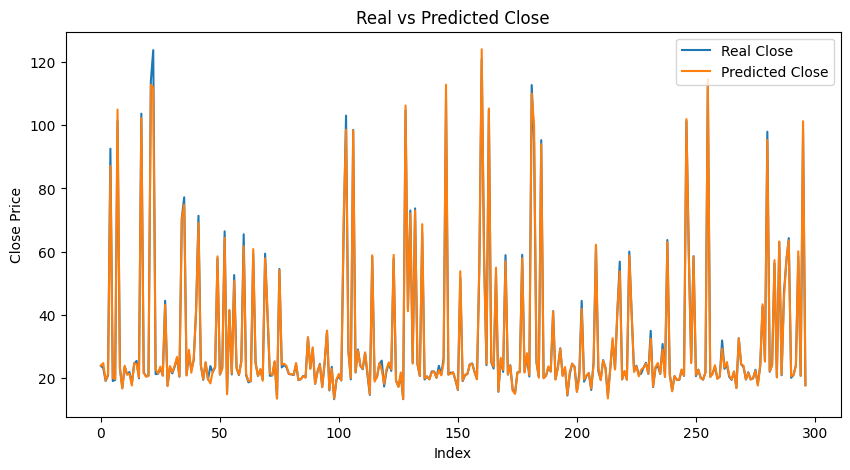

In [142]:
#linear_regression
train_linear_regression(X_train, X_test, y_train, y_test, scaler)

K-Nearest Neighbors Performance:
             MSE       MAE        R²      RMSE
Open    0.000065  0.003681  0.998363  0.008064
High    0.000165  0.006246  0.995930  0.012835
Low     0.000119  0.006250  0.997198  0.010897
Close   0.000220  0.007460  0.994533  0.014847
Volume  0.004177  0.042856  0.298576  0.064626


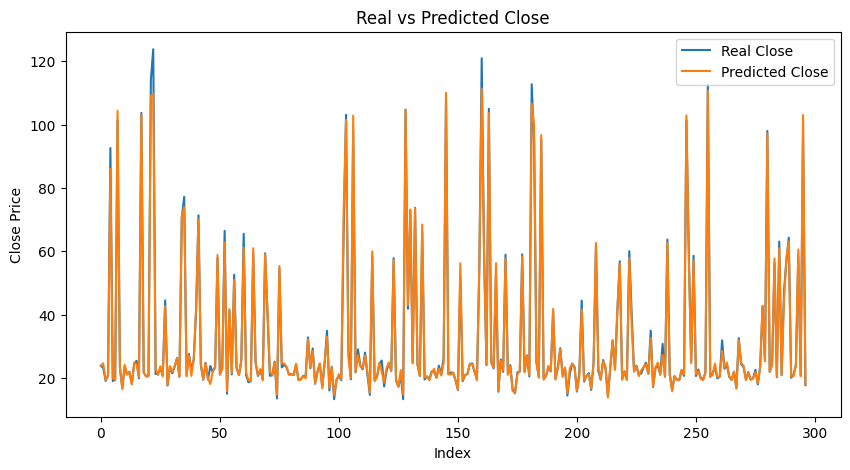

In [143]:
#knn
train_knn(X_train, X_test, y_train, y_test, scaler)

Decision Tree Performance:
             MSE       MAE        R²      RMSE
Open    0.000042  0.001329  0.998939  0.006493
High    0.000171  0.006310  0.995775  0.013076
Low     0.000160  0.006901  0.996224  0.012649
Close   0.000339  0.009425  0.991581  0.018423
Volume  0.009155  0.060209 -0.537588  0.095683


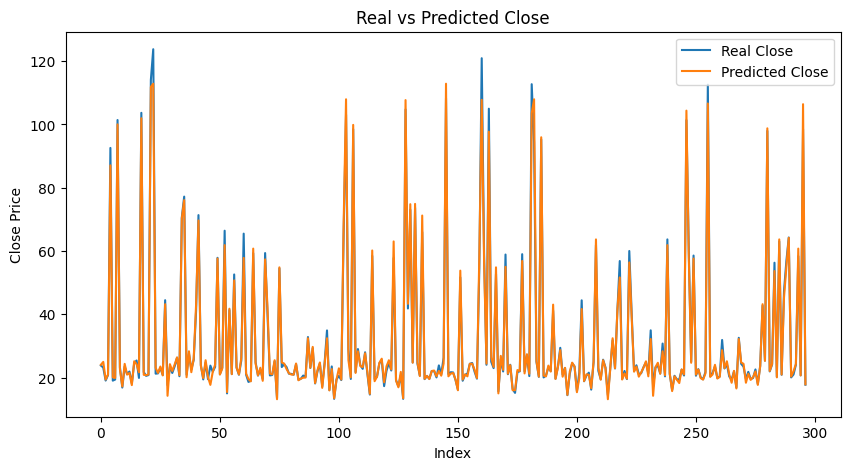

In [144]:
#DT
train_decision_tree(X_train, X_test, y_train, y_test, scaler)

Polynomial Regression Performance:
                 MSE       MAE        R²      RMSE
Open    2.698139e-10  0.000009  1.000000  0.000016
High    1.041401e-04  0.004709  0.997427  0.010205
Low     8.019044e-05  0.004725  0.998108  0.008955
Close   1.563175e-04  0.006208  0.996123  0.012503
Volume  3.965517e-03  0.041540  0.334009  0.062972


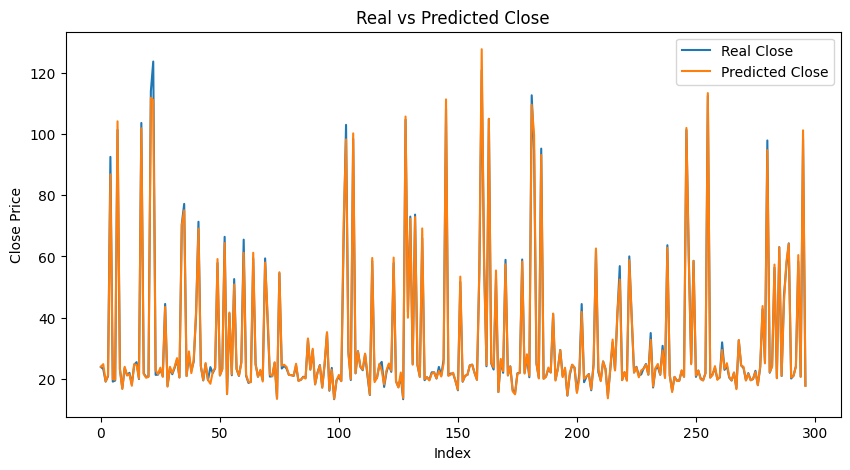

In [145]:
#polynomial_regression
train_polynomial_regression(X_train, X_test, y_train, y_test, scaler)


#usage (hybrid system)

In [146]:
#to train the system
def train_system(data,window,threshold):
  xgboost_create_models(data, window = window, threshold = threshold)
  data = pd.read_csv(data)
  (X_train, X_test, y_train, y_test), scaler = data_preprocessing(data, TESTING_RANGE, SCALER_CHOICE)
  train_linear_regression(X_train, X_test, y_train, y_test, scaler)



#regrssion
def predict(data,model="linear_regression_model.pkl",scaler="scaler.pkl"):

    data2 = data.copy()

    data2.drop(columns=data2.columns.difference(['Open', 'High', 'Low', 'Close', 'Volume']), inplace=True)
    data2 = data2.iloc[-1]

    model = joblib.load(model)
    scaler = MinMaxScaler()

    all_predictions = pd.DataFrame(columns=['Open_Pred', 'High_Pred', 'Low_Pred', 'Close_Pred', 'Volume_Pred'])

    data2 = data2.to_frame().T
    data2 = pd.DataFrame(scaler.fit_transform(data2), columns=data2.columns)
    y_new_pred = model.predict(data2)
    y_new_pred_df = pd.DataFrame(scaler.inverse_transform(y_new_pred),
                                 columns=['Open_Pred', 'High_Pred', 'Low_Pred', 'Close_Pred', 'Volume_Pred'])
    all_predictions = pd.concat([all_predictions, y_new_pred_df], ignore_index=True)

    # Drop the first row of the data to align the dataframes
    true_values = data2.iloc[1:].reset_index(drop=True)
    combined_df = pd.concat([true_values, all_predictions], axis=1)
    columns = ['Open_Pred', 'High_Pred', 'Low_Pred', 'Close_Pred', 'Volume_Pred']
    combined_df = combined_df[columns]
    combined_df.rename(columns = {'Open_Pred':'Open', 'High_Pred':'High', 'Low_Pred':'Low', 'Close_Pred':'Close', 'Volume_Pred':'Volume'}, inplace = True)
    return combined_df



#classification
def get_decision(df,window,model_buy,model_sell):
  #get datafram
  df = df.tail(window+10)
  df['SMA_20'] = ta.trend.sma_indicator(close=df['Close'], window=20)
  df['EMA_20'] = ta.trend.ema_indicator(close=df['Close'], window=20)
  df['RSI'] = ta.momentum.rsi(close=df['Close'], window=14)
  df['MACD'] = ta.trend.macd(close=df['Close'])
  df['BB_Lower'], df['BB_Middle'], df['BB_Upper'] = ta.volatility.bollinger_lband(close=df['Close']), ta.volatility.bollinger_mavg(close=df['Close']), ta.volatility.bollinger_hband(close=df['Close'])
  df['ADX'] = ta.trend.adx(high=df['High'], low=df['Low'], close=df['Close'])
  df['ATR'] = ta.volatility.average_true_range(high=df['High'], low=df['Low'], close=df['Close'])
  df['OBV'] = ta.volume.on_balance_volume(close=df['Close'], volume=df['Volume'])
  df['Ichimoku_A'], df['Ichimoku_B'] = ta.trend.ichimoku_a(high=df['High'], low=df['Low']), ta.trend.ichimoku_b(high=df['High'], low=df['Low'])
  df = preprocess(df,window)
  df = df.tail(1)

  features_data = {
      "Open_diff_prev": df["Open_diff_prev"],
      "Open_diff_avg": df["Open_diff_avg"],
      "High_diff_prev": df["High_diff_prev"],
      "High_diff_avg": df["High_diff_avg"],
      "Low_diff_prev": df["Low_diff_prev"],
      "Low_diff_avg": df["Low_diff_avg"],
      "Close_diff_prev": df["Close_diff_prev"],
      "Close_diff_avg": df["Close_diff_avg"],
      "Volume_diff_prev": df["Volume_diff_prev"],
      "Volume_diff_avg": df["Volume_diff_avg"],
      "SMA_20": df["SMA_20"],
      "EMA_20": df["EMA_20"],
      "RSI": df["RSI"],
      "MACD": df["MACD"],
      "BB_Lower": df["BB_Lower"],
      "BB_Middle": df["BB_Middle"],
      "BB_Upper": df["BB_Upper"],
      "ADX": df["ADX"],
      "ATR": df["ATR"],
      "OBV": df["OBV"],
      "Ichimoku_A": df["Ichimoku_A"],
      "Ichimoku_B": df["Ichimoku_B"],
  }

  features = pd.DataFrame(features_data)
  # Load and use models
  loaded_model_buy = load_model(model_buy)
  loaded_model_sell = load_model(model_sell)
  #get decision
  decision = predict_classify(loaded_model_buy,loaded_model_sell,features)
  return decision


#hybrid system
def get_signal(df,regression_model,scaler,window,model_buy,model_sell) :
  df2 = df
  predicted_data = predict(df2,regression_model,scaler)
  records = pd.concat([df, predicted_data], ignore_index=True, axis=0)
  decision = get_decision(records,window,model_buy,model_sell)
  return decision




In [147]:
#example usage
data = "raw_data.csv"
threshold = 0.2
df = pd.read_csv("raw_data.csv")
window = 20
regression_model = "linear_regression_model.pkl"
scaler = "scaler.pkl"
model_buy = "xgboost_model_buy.pkl"
model_sell = "xgboost_model_sell.pkl"


Buy Model - Accuracy: 1.0
Buy Model - Precision: 1.0
Buy Model - Recall: 1.0
Buy Model - F1-score: 1.0
Buy Model - Mean Squared Error: 0.0
Sell Model - Accuracy: 0.9166666666666666
Sell Model - Precision: 0.9090909090909091
Sell Model - Recall: 0.9090909090909091
Sell Model - F1-score: 0.9090909090909091
Sell Model - Mean Squared Error: 0.08333333333333333
Linear Regression Performance:
                 MSE       MAE        R²      RMSE
Open    3.068121e-10  0.000009  1.000000  0.000018
High    8.425257e-05  0.004502  0.997918  0.009179
Low     5.561852e-05  0.004277  0.998688  0.007458
Close   1.353499e-04  0.005797  0.996643  0.011634
Volume  4.095597e-03  0.043001  0.312163  0.063997


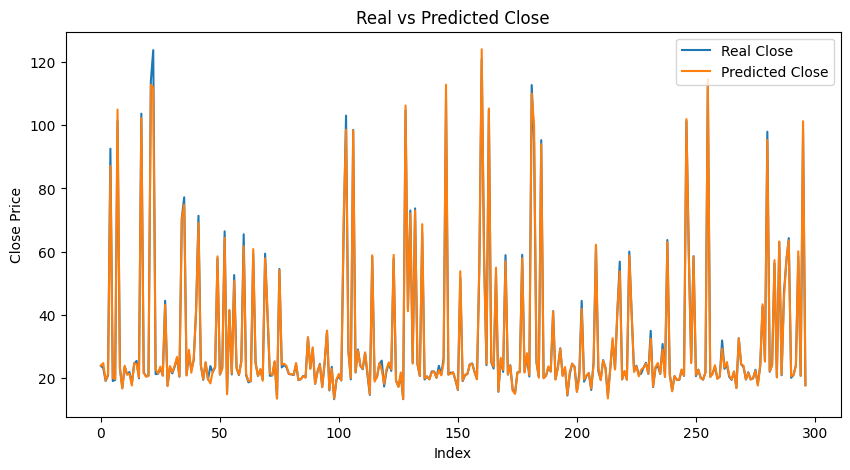

In [148]:
#to train the system
train_system(data,window,threshold)


In [149]:
#to get signals from the system
decision = get_signal(df,regression_model,scaler,window,model_buy,model_sell)
print(decision)


hold


#backtest

In [ ]:
#backtesting
!pip install backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import numpy as np

In [ ]:

# Load dataset
data_test = "raw_data_test.csv"
df = pd.read_csv(data_test)
# Drop rows with NaN values
df.dropna(inplace=True)

class MyStrategy(Strategy):

    def init(self):
        # Initialize an empty DataFrame to store historical data
        self.df_single = pd.DataFrame(columns=['date', 'Open', 'High', 'Low', 'Close', 'Volume'])

    def next(self):
        # Get current indicators
        current_df = {
            'date': self.data.date[-1],
            'Open': self.data.Open[-1],
            'High': self.data.High[-1],
            'Low': self.data.Low[-1],
            'Close': self.data.Close[-1],
            'Volume': self.data.Volume[-1]
        }

        # Convert current_df into a DataFrame and append it to df_single
        df_single_row = pd.DataFrame([current_df])
        self.df_single = pd.concat([self.df_single, df_single_row], ignore_index=True)



        # Check if the length of df_single is sufficient
        if len(self.df_single) < window + 20:
            pass
        else:

            # Generate signal using the full df_single
            self.df_single['Open'] = pd.to_numeric(self.df_single['Open'])
            self.df_single['High'] = pd.to_numeric(self.df_single['High'])
            self.df_single['Low'] = pd.to_numeric(self.df_single['Low'])
            self.df_single['Close'] = pd.to_numeric(self.df_single['Close'])
            self.df_single['Volume'] = pd.to_numeric(self.df_single['Volume'])
            signal = get_signal(self.df_single, regression_model, scaler, window, model_buy, model_sell)

            # Execute trades based on the signal
            if "buy" in signal:
                self.position.close()
                self.buy()
            elif "sell" in signal:
                self.position.close()
                self.sell()

# Assuming get_signal, regression_model, scaler, model_buy, model_sell are defined elsewhere

bt = Backtest(df, MyStrategy, cash=1000, commission=0.0, exclusive_orders=False)
output = bt.run()
print(output)

In [ ]:
#another test
# Load dataset
data_test = "TESTx.csv"
df = pd.read_csv(data_test)
# Drop rows with NaN values
df.dropna(inplace=True)

class MyStrategy(Strategy):

    def init(self):
        # Initialize an empty DataFrame to store historical data
        self.df_single = pd.DataFrame(columns=['date', 'Open', 'High', 'Low', 'Close', 'Volume'])

    def next(self):
        # Get current indicators
        current_df = {
            'date': self.data.Date[-1],
            'Open': self.data.Open[-1],
            'High': self.data.High[-1],
            'Low': self.data.Low[-1],
            'Close': self.data.Close[-1],
            'Volume': self.data.Volume[-1]
        }

        # Convert current_df into a DataFrame and append it to df_single
        df_single_row = pd.DataFrame([current_df])
        self.df_single = pd.concat([self.df_single, df_single_row], ignore_index=True)



        # Check if the length of df_single is sufficient
        if len(self.df_single) < window + 20:
            pass
        else:

            # Generate signal using the full df_single
            self.df_single['Open'] = pd.to_numeric(self.df_single['Open'])
            self.df_single['High'] = pd.to_numeric(self.df_single['High'])
            self.df_single['Low'] = pd.to_numeric(self.df_single['Low'])
            self.df_single['Close'] = pd.to_numeric(self.df_single['Close'])
            self.df_single['Volume'] = pd.to_numeric(self.df_single['Volume'])
            signal = get_signal(self.df_single, regression_model, scaler, window, model_buy, model_sell)

            # Execute trades based on the signal
            if "buy" in signal:
                self.buy()
            elif "sell" in signal:
                self.position.close()


# Assuming get_signal, regression_model, scaler, model_buy, model_sell are defined elsewhere

bt = Backtest(df, MyStrategy, cash=1000, commission=0.0, exclusive_orders=False)
output = bt.run()
print(output)

#to save the notebook

In [ ]:
!pip install nbconvert
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc

In [124]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [131]:

!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/classification_regression.ipynb"


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/classification_regression.ipynb to pdf
/usr/local/lib/python3.10/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  warn(
[NbConvertApp] Support files will be in classification_regression_files/
[NbConvertApp] Making directory ./classification_regression_files
[NbConvertApp] Making directory ./classification_regression_files
[NbConvertApp] Making directory ./classification_regression_files
[NbConvertApp] Making directory ./classification_regression_files
[NbConvertApp] Writing 119916 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp]